In [144]:
import pandas as pd
import numpy as np
import datetime

# models
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# helpers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Problem 1: In which habitat does a mushroom belong?

In [110]:
# Import Datasets
mushroom_df = pd.read_csv('data/mushrooms.csv')
mushroom_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [111]:
# Frequency distribution of habitat classes
pd.crosstab(index=mushroom_df["habitat"], columns="count")

col_0,count
habitat,
d,3148
g,2148
l,832
m,292
p,1144
u,368
w,192


In [112]:
# Create feature and target dataframes
# - apply one-hot encoding to categorical columns
# - separate the feature and target data
feature_cols = mushroom_df.columns.drop('habitat')
feature_df = pd.get_dummies(mushroom_df[feature_cols])
target_outcome = mushroom_df['habitat']

In [113]:
# Split the data into train (85%) and test (15%) sets
X_train, X_test, y_train, y_test = train_test_split(feature_df, target_outcome, test_size=0.15, random_state=42, stratify=np.ravel(target_outcome))

## Decision trees

In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

### Pruning using Cost Complexity

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

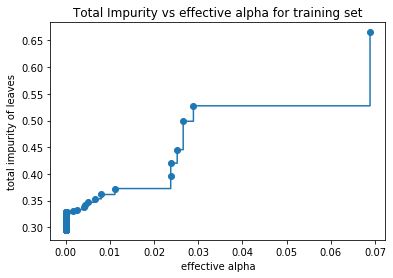

In [75]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [76]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.08036981078116012


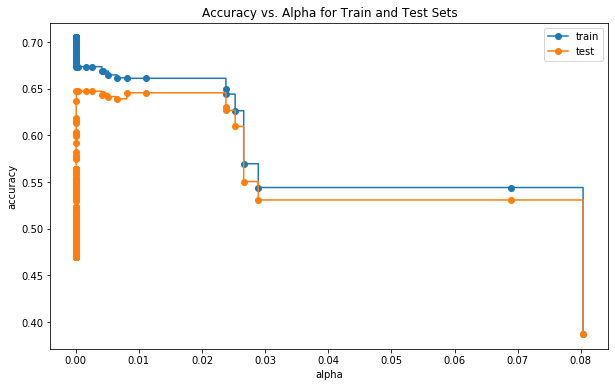

In [77]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs. Alpha for Train and Test Sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

### Feature Importances

In [78]:
feature_importances = dict(zip(feature_df.columns, tree_clf.feature_importances_))
top_fifteen = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:15]

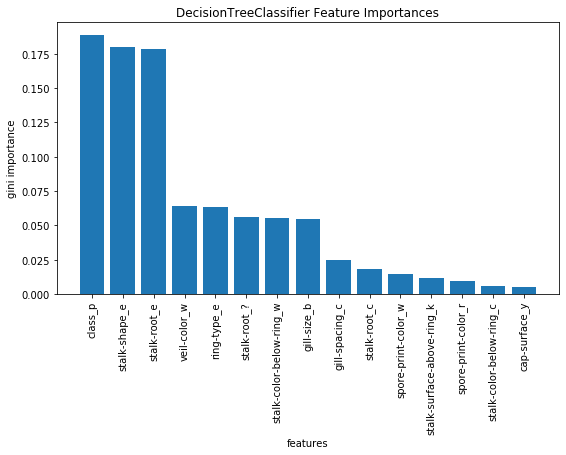

In [79]:
plt.figure(figsize=(9, 5))
plt.xlabel('features')
plt.ylabel('gini importance')
plt.title("DecisionTreeClassifier Feature Importances")
plt.bar(range(len(top_fifteen)), [f[1] for f in top_fifteen])
plt.xticks(range(len(top_fifteen)), [f[0] for f in top_fifteen], rotation=90)
plt.show()

In [80]:
top_feats = [f[0] for f in top_fifteen][:12]
tree_clf_2 = tree.DecisionTreeClassifier(ccp_alpha=0.017)
tree_clf_2 = tree_clf.fit(X_train[top_feats], y_train)

y_pred = tree_clf_2.predict(X_test[top_feats])

### DecisionTree Graph

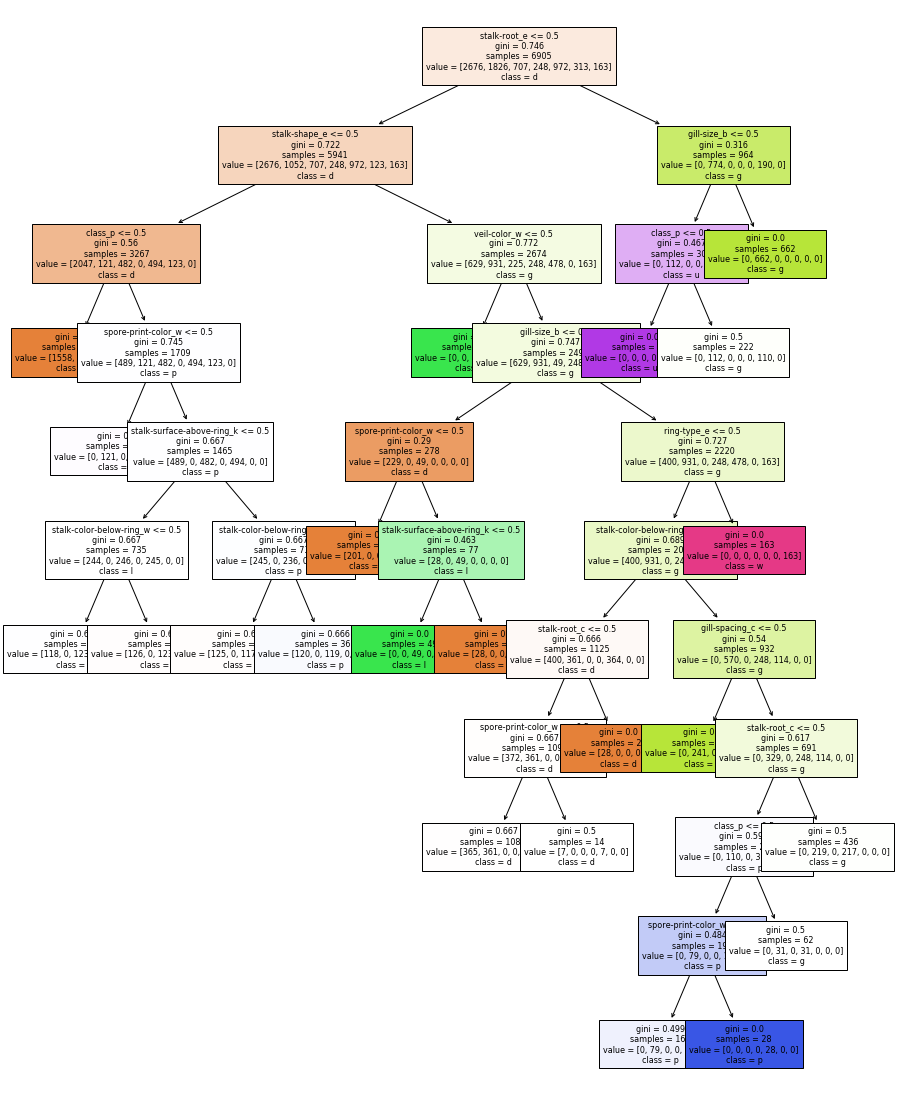

In [81]:
fig, ax = plt.subplots(figsize=(15, 20))
tree.plot_tree(tree_clf_2, ax=ax, feature_names=top_feats, class_names=tree_clf_2.classes_ , fontsize=8, filled=True)
plt.show()

### Performance

In [84]:
print(classification_report(y_test, y_pred, labels=tree_clf_2.classes_, zero_division=0))

              precision    recall  f1-score   support

           d       0.64      0.89      0.74       472
           g       0.77      0.66      0.71       322
           l       1.00      0.25      0.40       125
           m       0.00      0.00      0.00        44
           p       0.31      0.29      0.30       172
           u       0.62      0.67      0.64        55
           w       1.00      1.00      1.00        29

    accuracy                           0.64      1219
   macro avg       0.62      0.54      0.54      1219
weighted avg       0.65      0.64      0.61      1219



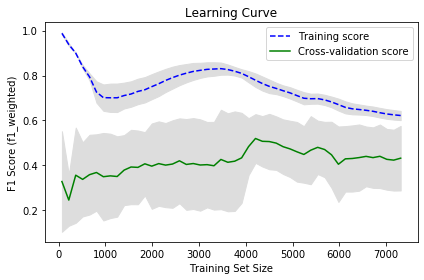

In [85]:
def plot_learning_curve(classifier, feature_df, target, scoring):
    train_sizes, train_scores, test_scores = learning_curve(classifier, 
                                                            feature_df, 
                                                            target,
                                                            cv=10,
                                                            scoring=scoring,
                                                            n_jobs=-1, 
                                                            train_sizes=np.linspace(0.01, 1.0, 50))

    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="blue",  label="Training score")
    plt.plot(train_sizes, test_mean, color="green", label="Cross-validation score")

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("F1 Score ({})".format(scoring)), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
plot_learning_curve(tree_clf_2, feature_df, target_outcome, 'f1_weighted')

## Support Vector Machines

In [86]:
# sklearn model: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svc_clf_rbf = SVC(kernel='rbf')
svc_clf_rbf = svc_clf_rbf.fit(X_train, y_train)

In [87]:
svc_clf_lin = SVC(kernel='linear')
svc_clf_lin = svc_clf_lin.fit(X_train, y_train)

### RBF Kernel Performance

In [88]:
y_pred = svc_clf_rbf.predict(X_test)

print(classification_report(y_test, y_pred, labels=svc_clf_rbf.classes_, zero_division=0))

              precision    recall  f1-score   support

           d       0.71      0.76      0.73       472
           g       0.62      0.72      0.66       322
           l       1.00      0.25      0.40       125
           m       0.00      0.00      0.00        44
           p       0.30      0.43      0.35       172
           u       0.56      0.35      0.43        55
           w       1.00      1.00      1.00        29

    accuracy                           0.61      1219
   macro avg       0.60      0.50      0.51      1219
weighted avg       0.63      0.61      0.59      1219



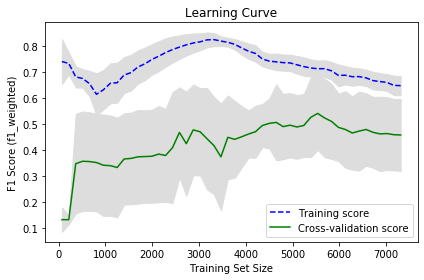

In [89]:
plot_learning_curve(svc_clf_rbf, feature_df, target_outcome, 'f1_weighted')

### Linear Kernel Performance

In [90]:
y_pred = svc_clf_lin.predict(X_test)

print(classification_report(y_test, y_pred, labels=svc_clf_lin.classes_))

              precision    recall  f1-score   support

           d       0.69      0.81      0.75       472
           g       0.66      0.64      0.65       322
           l       0.62      0.34      0.44       125
           m       0.44      0.45      0.45        44
           p       0.31      0.28      0.29       172
           u       0.57      0.58      0.58        55
           w       1.00      1.00      1.00        29

    accuracy                           0.62      1219
   macro avg       0.61      0.59      0.59      1219
weighted avg       0.62      0.62      0.61      1219



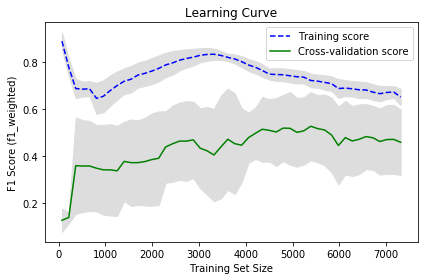

In [91]:
plot_learning_curve(svc_clf_lin, feature_df, target_outcome, 'f1_weighted')

### GridSearchCV

In [24]:
params_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear']}

In [25]:
svm_model = GridSearchCV(SVC(), params_grid, cv=5, scoring='f1_weighted')
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [48]:
svc_clf_tuned = svm_model.best_estimator_
svc_clf_tuned.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Tuned Model's Performance

In [114]:
y_pred = svc_clf_tuned.predict(X_test)

print(classification_report(y_test, y_pred, labels=svc_clf_tuned.classes_, zero_division=0))

              precision    recall  f1-score   support

           d       0.60      0.97      0.74       472
           g       0.70      0.74      0.72       322
           l       1.00      0.25      0.40       125
           m       0.00      0.00      0.00        44
           p       0.53      0.05      0.09       172
           u       0.74      0.47      0.58        55
           w       1.00      1.00      1.00        29

    accuracy                           0.65      1219
   macro avg       0.65      0.50      0.50      1219
weighted avg       0.65      0.65      0.58      1219



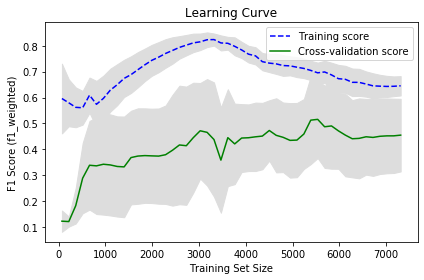

In [115]:
plot_learning_curve(svc_clf_tuned, feature_df, target_outcome, 'f1_weighted')

## Boosting

In [58]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### GridSearchCV

In [59]:
params_grid = {'n_estimators': [50, 100, 200],  
              'learning_rate': [0.6, 0.8, 1.0],
              'ccp_alpha': [0.15, 0.3, 0.5]}

In [60]:
gb_model = GridSearchCV(GradientBoostingClassifier(), params_grid, cv=5, scoring='f1_weighted')
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

### Tuned Model's Performance

In [64]:
gb_clf_tuned = gb_model.best_estimator_
gb_clf_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.15, criterion='friedman_mse', init=None,
                           learning_rate=0.6, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [66]:
y_pred = gb_clf_tuned.predict(X_test)

print(classification_report(y_test, y_pred, labels=gb_clf_tuned.classes_, zero_division=0))

              precision    recall  f1-score   support

           d       0.39      1.00      0.56       472
           g       0.00      0.00      0.00       322
           l       0.00      0.00      0.00       125
           m       0.00      0.00      0.00        44
           p       0.00      0.00      0.00       172
           u       0.00      0.00      0.00        55
           w       0.00      0.00      0.00        29

    accuracy                           0.39      1219
   macro avg       0.06      0.14      0.08      1219
weighted avg       0.15      0.39      0.22      1219



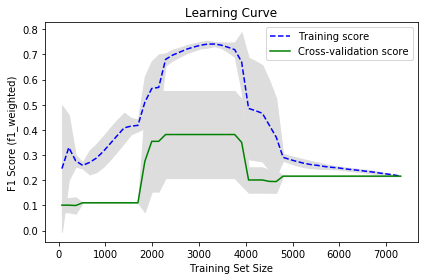

In [92]:
plot_learning_curve(gb_clf_tuned, feature_df, target_outcome, 'f1_weighted')

# Problem 2: Is this Kiva loan for an agricultural project? 

In [93]:
# Import Datasets
kiva_df = pd.read_csv('data/kiva_loans.csv')
kiva_df.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [94]:
# Frequency distribution of sector classes
pd.crosstab(index=kiva_df["sector"], columns="count")

col_0,count
sector,
Agriculture,180302
Arts,12060
Clothing,32742
Construction,6268
Education,31013
Entertainment,830
Food,136657
Health,9223
Housing,33731


In [95]:
# Add new `days_to_fund` feature
kiva_df['days_to_fund'] = (pd.to_datetime(kiva_df.funded_time) - pd.to_datetime(kiva_df.posted_time)).dt.days
kiva_df = kiva_df[kiva_df.days_to_fund >= 0]

In [96]:
# Add new count features `female_borrowers` and `male_borrowers`

def recipient_genders(x):
    lst = x.replace(" ", "").split(',') if not pd.isna(x) else []
    return lst.count('female'), lst.count('male')

gender_counts = kiva_df.borrower_genders.apply(recipient_genders).str
kiva_df.loc[:, 'female_borrowers'] = gender_counts[0]
kiva_df.loc[:, 'male_borrowers'] = gender_counts[1]

In [97]:
# Add target feature `is_agricultural_loan` to dataframe
kiva_df['is_agricultural_loan'] = np.where(kiva_df['sector']=='Agriculture', True, False)

In [98]:
# Select a subset of features to exclude timeseries data
rel_cols = ['days_to_fund', 'funded_amount', 'loan_amount', 'term_in_months', 'repayment_interval','female_borrowers', 'male_borrowers', 'activity', 'country', 'is_agricultural_loan']
kiva_subset = kiva_df[rel_cols].copy()
kiva_subset.head()

,days_to_fund,funded_amount,loan_amount,term_in_months,repayment_interval,female_borrowers,male_borrowers,activity,country,is_agricultural_loan
0,1.0,300.0,300.0,12.0,irregular,1,0,Fruits & Vegetables,Pakistan,False
1,1.0,575.0,575.0,11.0,irregular,2,0,Rickshaw,Pakistan,False
2,0.0,150.0,150.0,43.0,bullet,1,0,Transportation,India,False
3,0.0,200.0,200.0,11.0,irregular,1,0,Embroidery,Pakistan,False
4,0.0,400.0,400.0,14.0,monthly,1,0,Milk Sales,Pakistan,False


In [99]:
# Create feature and target dataframes
# - apply one-hot encoding to categorical columns
# - separate the feature and target data
kiva_feature_cols = kiva_subset.drop(columns = ['is_agricultural_loan']).columns
kiva_features = pd.get_dummies(kiva_subset[kiva_feature_cols], prefix='', prefix_sep='')
kiva_target = kiva_subset[['is_agricultural_loan']]

In [100]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(kiva_features, kiva_target, test_size=0.20, random_state=42)

## k-nearest neighbors

In [101]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
neigh_clf = KNeighborsClassifier(n_neighbors=15)
neigh_clf.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [102]:
y_pred = neigh_clf.predict(X_test)

### Performance (k=15)

In [103]:
print(classification_report(y_test, y_pred, labels=neigh_clf.classes_))

              precision    recall  f1-score   support

       False       0.88      0.96      0.92     91229
        True       0.85      0.63      0.72     33346

    accuracy                           0.87    124575
   macro avg       0.86      0.79      0.82    124575
weighted avg       0.87      0.87      0.86    124575



### Performance (k=1)

In [105]:
neigh_clf_one = KNeighborsClassifier(n_neighbors=1)
neigh_clf_one.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [106]:
y_pred = neigh_clf_one.predict(X_test)

In [107]:
print(classification_report(y_test, y_pred, labels=neigh_clf_one.classes_))

              precision    recall  f1-score   support

       False       0.93      0.92      0.93     91229
        True       0.79      0.82      0.80     33346

    accuracy                           0.89    124575
   macro avg       0.86      0.87      0.87    124575
weighted avg       0.89      0.89      0.89    124575



### Plot the F1 score as a function of k

Text(0, 0.5, 'F1 Score (binary)')

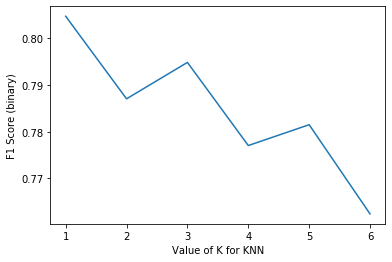

In [108]:
# https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75
from sklearn import metrics

k_range = range(1,7)
scores = {}
scores_list = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, np.ravel(y_train))
    y_pred = knn.predict(X_test)
    scores[k] = metrics.f1_score(y_test, y_pred, average='binary')
    scores_list.append(metrics.f1_score(y_test, y_pred, average='binary'))
    

plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 Score (binary)')

## Neural networks

In [116]:
# In order to reduce training times, I sampled 50,000 rows from the data
kiva_final = kiva_subset.sample(n=50000, random_state=1)

In [117]:
# Create feature and target dataframes
# - apply one-hot encoding to categorical columns
# - separate the feature and target data
kiva_feature_cols = kiva_final.drop(columns = ['is_agricultural_loan']).columns
kiva_features = pd.get_dummies(kiva_final[kiva_feature_cols], prefix='', prefix_sep='')
kiva_target = kiva_final[['is_agricultural_loan']]

In [118]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(kiva_features, kiva_target, test_size=0.20, random_state=42)

In [120]:
len(kiva_features.columns)

250

In [123]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(250,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [133]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4016      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 4,305
Trainable params: 4,305
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_split = 0.15, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 53us/sample - loss: 0.0011 - accuracy: 0.9993


In [153]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [154]:
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.020132,0.996265,0.006401,1.000000,45
46,0.012079,0.997529,0.000007,1.000000,46
47,0.005879,0.998824,0.000222,0.999833,47
48,0.021185,0.996441,0.000948,0.999833,48
49,0.014073,0.997147,0.000496,0.999500,49


In [155]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

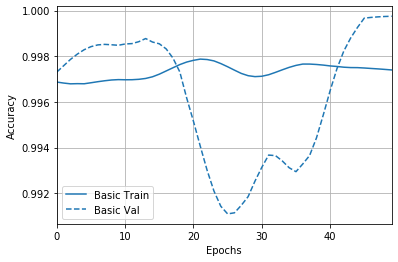

In [156]:
# Plot the learning curve for accuracy
plotter.plot({'Basic': history}, metric = "accuracy")

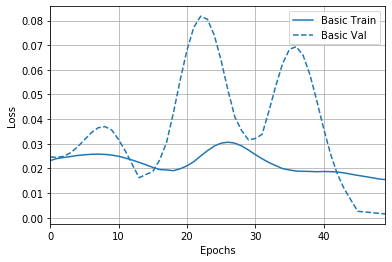

In [157]:
# Plot the learning curve for loss
plotter.plot({'Basic': history}, metric = "loss")